In [1]:
import pandas as pd
from cryptocmd import CmcScraper
import tensorflow as tf
from tensorflow.keras import layers
from datetime import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from matplotlib import style, pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend
import seaborn as sns


tf.random.set_seed(42)
WINDOW = 7
HALVING_DATES = [datetime.strptime(date, "%d/%m/%Y") for date in ['09/07/2016', '11/05/2020', '02/03/2024']]

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
%matplotlib inline
style.use('ggplot')

In [4]:
def get_crypto_df(sym):
    scraper = CmcScraper(sym)
    return scraper.get_dataframe()

In [5]:
def days_till_halving(row, halving_dates=HALVING_DATES):
    date = row.Date
    closest_halving_index = 0
    while halving_dates[closest_halving_index] < date:
        closest_halving_index += 1
    delta = halving_dates[closest_halving_index] - date
    return delta.days

In [6]:
def block_size(row, halving_dates=HALVING_DATES):
    date = row.Date
    i = 0
    size = 25
    while date > halving_dates[i]:
        i += 1
        size /= 2
    return size

In [7]:
def get_label_values_from_dataframe(df, window_size=WINDOW):
    res = df.copy()
    y = df.iloc[window_size:]["Increment"].to_numpy()
    x = np.array([res.iloc[i: window_size + i].to_numpy() for i in range(len(res) - window_size)])
    return x, y

In [8]:
def shuffle_together(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [9]:
def create_Xt_Yt(X, y, split_size=0.9):
    split = int(len(X) * split_size)
    X_train = X[0:split]
    Y_train = y[0:split]
    X_train, Y_train = shuffle_together(X_train, Y_train)
    X_test = X[split:]
    Y_test = y[split:]
    return X_train, X_test, Y_train, Y_test

In [10]:
def find_gap(df):
    gap_res = []
    gap_res.append(0)
    for i in range(0,len(df)-1):
        gap = abs(df["Open"][i+1] - df["Close"][i]) / df["Close"][i]
        gap_res.append(gap)
    return pd.DataFrame(gap_res)

In [11]:
def find_emad(df, fast, slow):
    params = [fast,slow]
    params = pd.DataFrame(params)
    faster = int(params.min())
    slower = int(params.max())
    alpha_slow = 2 / (slower + 1)
    sma_slow = []
    ema_slow = []
    for i in range(0,len(df)):
        smas = 0 if (i < (slower-1)) else df["Close"][i-(slower-1):i+1].mean()
        sma_slow.append(smas)
        if i < (slower-1):
            emas = 0
        elif i == (slower-1):
            emas = df["Close"][i-(slower-1):i+1].mean()
        else:
            emas = (alpha_slow * df["Close"][i]) + ((1 - alpha_slow)*ema_slow[i-1])
        ema_slow.append(emas)
    alpha_fast = 2 / (faster + 1)
    sma_fast = []
    ema_fast = []
    for i in range(0,len(df)):
        smaf = 0 if (i < (slower-1)) else df["Close"][i-(faster-1):i+1].mean()
        sma_fast.append(smaf)
        if i < (slower-1):
            emaf = 0
        elif i == (slower-1):
            emaf = df["Close"][i-(faster-1):i+1].mean()
        else:
            emaf = (alpha_fast * df["Close"][i]) + ((1 - alpha_fast)*ema_fast[i-1])
        ema_fast.append(emaf)
    emad_res = pd.DataFrame(ema_fast) - pd.DataFrame(ema_slow)
    return emad_res

In [12]:
def find_stoch(df, k, smooth):
    params = [k,smooth]
    params = pd.DataFrame(params)
    smooth_per = int(params.min())
    k_per = int(params.max())
    otstup = (k_per + smooth_per)-1
    max_high = []
    min_low = []
    k_res = []
    for i in range(0,len(df)):
        high = 0 if (i < (k_per-1)) else df["High"][i-(k_per-1):i+1].max()
        low = 0 if (i < (k_per-1)) else df["Low"][i-(k_per-1):i+1].min()
        k_pokaz = 0 if (i < (k_per-1)) else (df["Close"][i] - low) / (high - low)
        max_high.append(high)
        min_low.append(low)
        k_res.append(k_pokaz)
    stoch_k = pd.DataFrame(k_res)
    stoch_res = []
    for i in range(0,len(df)):
        smooth_k = 0 if (i < (otstup-1)) else stoch_k[i-(smooth_per-1):i+1].mean()
        stoch_res.append(float(smooth_k))
    return pd.DataFrame(stoch_res)

In [13]:
def find_volat(df, period):
    volat_res = []
    for i in range(0,len(df)):
        volat = 0 if (i < (period-1)) else df["Close"][i-(period-1):i+1].std()
        volat_res.append(volat)
    return pd.DataFrame(volat_res)

In [14]:
def plot_confusion_matrix(y_test, y_preds, title):
    sns.set(font_scale=2)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),                     
                     annot=True,                
                     cmap="Oranges",linewidths=.10, fmt= '.0f',
                     annot_kws={
                    'fontsize': 30,
                    })
    plt.title(title, fontsize=30)
    plt.xlabel("Valor real", fontsize=25)
    plt.ylabel("Valor predicho", fontsize=25)

In [15]:
df_original = get_crypto_df('BTC')[::-1]
df_original

,Date,Open,High,Low,Close,Volume,Market Cap
3407,2013-04-28,135.300003,135.979996,132.100006,134.210007,0.000000e+00,1.488567e+09
3406,2013-04-29,134.444000,147.488007,134.000000,144.539993,0.000000e+00,1.603769e+09
3405,2013-04-30,144.000000,146.929993,134.050003,139.000000,0.000000e+00,1.542813e+09
3404,2013-05-01,139.000000,139.889999,107.720001,116.989998,0.000000e+00,1.298955e+09
3403,2013-05-02,116.379997,125.599998,92.281898,105.209999,0.000000e+00,1.168517e+09
...,...,...,...,...,...,...,...
4,2022-08-22,21531.463849,21531.463849,20939.184173,21398.908350,3.166650e+10,4.093401e+11
3,2022-08-23,21401.045670,21646.203762,20955.138156,21528.087372,3.187828e+10,4.118332e+11
2,2022-08-24,21526.455593,21783.075723,21195.006695,21395.020071,3.196225e+10,4.093085e+11
1,2022-08-25,21395.458390,21789.636836,21362.441260,21600.905142,3.102868e+10,4.132678e+11


In [16]:
fast_emad = 8
slow_emad = 18
k_stoch = 5
smooth_stoch = 3
period_volat = 6
window_autocorr = 30
lag_autocorr = 4
log_ret = pd.Series(np.log(df_original['Close']).diff())
df_original['Autocorrelacion'] = log_ret.rolling(window=window_autocorr,
min_periods=window_autocorr, center=False).apply(lambda row: row.autocorr(lag=lag_autocorr),raw=False)

In [17]:
df_original['Gap'] = find_gap(df_original)
df_original['Vol_to_MC'] = df_original.apply(lambda row: row.Volume / row["Market Cap"], axis=1)
df_original['Increment'] = df_original.apply(lambda row: (row.Close - row.Open) / row.Open, axis=1)
df_original['Increment_is_negative'] = df_original["Increment"] < 0
df_original['Increment'] = np.abs(df_original["Increment"])
df_original['Highest_difference'] = df_original.apply(lambda row: (row.High - row.Low) / row.Low, axis=1)
df_original['EMAD'] = find_emad(df_original, fast_emad, slow_emad)
df_original['Stoch'] = find_stoch(df_original, k_stoch, smooth_stoch)
df_original['Volatility'] = find_volat(df_original, period_volat)
df_original['DTH'] = df_original.apply(days_till_halving, axis=1)
df_original['BS'] = df_original.apply(block_size, axis=1)
df_original = df_original.set_index('Date').astype('float32')

In [18]:
df_original

,Open,High,Low,Close,Volume,Market Cap,Autocorrelacion,Gap,Vol_to_MC,Increment,Increment_is_negative,Highest_difference,EMAD,Stoch,Volatility,DTH,BS
Date,,,,,,,,,,,,,,,,,
2013-04-28,135.300003,135.979996,132.100006,134.210007,0.000000e+00,1.488567e+09,NaN,0.063927,0.000000,0.008056,1.0,0.029372,4.778623,-19.771576,509.236084,1168.0,25.00
2013-04-29,134.444000,147.488007,134.000000,144.539993,0.000000e+00,1.603769e+09,NaN,0.032777,0.000000,0.075094,0.0,0.100657,3.914974,-18.539026,155.702087,1167.0,25.00
2013-04-30,144.000000,146.929993,134.050003,139.000000,0.000000e+00,1.542813e+09,NaN,0.230874,0.000000,0.034722,1.0,0.096083,0.806205,-12.943802,253.136566,1166.0,25.00
2013-05-01,139.000000,139.889999,107.720001,116.989998,0.000000e+00,1.298955e+09,NaN,0.321167,0.000000,0.158345,1.0,0.298645,-2.757026,-7.437809,819.610779,1165.0,25.00
2013-05-02,116.379997,125.599998,92.281898,105.209999,0.000000e+00,1.168518e+09,NaN,0.190588,0.000000,0.095979,1.0,0.361047,-4.085466,-6.451854,1072.546387,1164.0,25.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-22,21531.462891,21531.462891,20939.183594,21398.908203,3.166650e+10,4.093401e+11,-0.080892,0.000157,0.077360,0.006156,1.0,0.028286,0.000000,0.000000,0.000000,558.0,6.25
2022-08-23,21401.044922,21646.203125,20955.138672,21528.087891,3.187828e+10,4.118332e+11,-0.125896,0.000282,0.077406,0.005936,0.0,0.032978,0.000000,0.000000,0.000000,557.0,6.25
2022-08-24,21526.455078,21783.076172,21195.005859,21395.019531,3.196225e+10,4.093085e+11,-0.128158,0.003447,0.078088,0.006106,1.0,0.027746,0.000000,0.000000,0.000000,556.0,6.25


In [19]:
lishnee = [fast_emad, slow_emad, k_stoch, smooth_stoch, period_volat, k_stoch+smooth_stoch-1,
window_autocorr+1, lag_autocorr]
row_del = int(max(lishnee))
row_del

31

In [20]:
df_original = df_original[row_del-1:]
df_original = df_original.fillna(0)

In [21]:
df_original

,Open,High,Low,Close,Volume,Market Cap,Autocorrelacion,Gap,Vol_to_MC,Increment,Increment_is_negative,Highest_difference,EMAD,Stoch,Volatility,DTH,BS
Date,,,,,,,,,,,,,,,,,
2013-05-28,129.770004,130.580002,125.599998,129.000000,0.000000e+00,1.446190e+09,-0.244994,0.019123,0.000000,0.005934,1.0,0.039650,6.993731,-8.555168,729.266907,1138.0,25.00
2013-05-29,129.000000,132.589996,127.662003,132.300003,0.000000e+00,1.483735e+09,-0.157953,0.001561,0.000000,0.025581,0.0,0.038602,7.349885,-8.763894,779.401855,1137.0,25.00
2013-05-30,132.250000,132.250000,127.000000,128.798996,0.000000e+00,1.445054e+09,-0.105131,0.025194,0.000000,0.026095,1.0,0.041339,7.059991,-9.245500,675.606506,1136.0,25.00
2013-05-31,128.798996,129.899994,126.400002,129.000000,0.000000e+00,1.447870e+09,0.022435,0.003875,0.000000,0.001561,0.0,0.027690,6.994516,-8.198586,380.031067,1135.0,25.00
2013-06-01,128.815002,129.779999,127.198997,129.300003,0.000000e+00,1.451916e+09,-0.143317,0.053340,0.000000,0.003765,0.0,0.020291,6.631538,-6.889208,403.451416,1134.0,25.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-22,21531.462891,21531.462891,20939.183594,21398.908203,3.166650e+10,4.093401e+11,-0.080892,0.000157,0.077360,0.006156,1.0,0.028286,0.000000,0.000000,0.000000,558.0,6.25
2022-08-23,21401.044922,21646.203125,20955.138672,21528.087891,3.187828e+10,4.118332e+11,-0.125896,0.000282,0.077406,0.005936,0.0,0.032978,0.000000,0.000000,0.000000,557.0,6.25
2022-08-24,21526.455078,21783.076172,21195.005859,21395.019531,3.196225e+10,4.093085e+11,-0.128158,0.003447,0.078088,0.006106,1.0,0.027746,0.000000,0.000000,0.000000,556.0,6.25


In [22]:
min_max_scaler = MinMaxScaler()
df_original['Gap'] = min_max_scaler.fit_transform(df_original.Gap.values.reshape(-1,1))
df_original['Highest_difference'] = min_max_scaler.fit_transform(df_original.Highest_difference.values.reshape(-1,1))
df_original['Increment'] = min_max_scaler.fit_transform(df_original.Increment.values.reshape(-1,1))
df_original['Vol_to_MC'] = min_max_scaler.fit_transform(df_original.Vol_to_MC.values.reshape(-1,1))
df_original['EMAD'] = min_max_scaler.fit_transform(df_original.EMAD.values.reshape(-1,1))
df_original['Stoch'] = min_max_scaler.fit_transform(df_original.Stoch.values.reshape(-1,1))
df_original['Volatility'] = min_max_scaler.fit_transform(df_original.Volatility.values.reshape(-1,1))
df_original['Autocorrelacion'] = min_max_scaler.fit_transform(df_original.Autocorrelacion.values.reshape(-1,1))
df_original['DTH'] = min_max_scaler.fit_transform(df_original.DTH.values.reshape(-1,1))
df_original['BS'] = min_max_scaler.fit_transform(df_original.BS.values.reshape(-1,1))
df_original['Increment'] = df_original.apply(lambda row: -row.Increment if row.Increment_is_negative else row.Increment, axis=1)

In [23]:
delete_cols = ["Open", "Close", "High", "Low", "Market Cap", "Volume", "Increment_is_negative"]
for col in delete_cols:
    del df_original[col]

In [24]:
df_original

,Autocorrelacion,Gap,Vol_to_MC,Increment,Highest_difference,EMAD,Stoch,Volatility,DTH,BS
Date,,,,,,,,,,
2013-05-28,0.357091,0.032340,0.000000,-0.014236,0.051743,0.406979,0.009397,0.165129,0.812277,1.0
2013-05-29,0.418653,0.002639,0.000000,0.061374,0.050376,0.407010,0.009362,0.176481,0.811563,1.0
2013-05-30,0.456013,0.042606,0.000000,-0.062605,0.053947,0.406985,0.009283,0.152979,0.810849,1.0
2013-05-31,0.546237,0.006553,0.000000,0.003744,0.036136,0.406979,0.009456,0.086051,0.810136,1.0
2013-06-01,0.429005,0.090205,0.000000,0.009033,0.026480,0.406946,0.009673,0.091354,0.809422,1.0
...,...,...,...,...,...,...,...,...,...,...
2022-08-22,0.473157,0.000265,0.106035,-0.014770,0.036913,0.406354,0.010816,0.000000,0.398287,0.0
2022-08-23,0.441326,0.000476,0.106098,0.014242,0.043037,0.406354,0.010816,0.000000,0.397573,0.0
2022-08-24,0.439726,0.005829,0.107034,-0.014649,0.036208,0.406354,0.010816,0.000000,0.396859,0.0


In [25]:
X, Y = get_label_values_from_dataframe(df_original)
n_values = df_original.shape[1]

In [26]:
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_values, 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_values, 1))

In [35]:
model= tf.keras.Sequential([
    layers.Conv2D(input_shape = (WINDOW, n_values, 1),filters=16,kernel_size=3,padding='same'),
    layers.LeakyReLU(),
    layers.MaxPooling2D(pool_size=3),
    layers.Conv2D(filters=64,kernel_size=3,padding='same'),
    layers.LeakyReLU(),
    layers.MaxPooling2D(pool_size=2),
    layers.Lambda(lambda x: backend.squeeze(x, 2)),
    layers.LSTM(128,return_sequences=True),
    layers.Flatten(),
    layers.Dense(640),
    layers.LeakyReLU(),
    layers.Dense(32),
    layers.LeakyReLU(),
    layers.Dense(1),
    layers.Activation('linear')
], name="multivariable")


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=25, min_lr=0.000001,
verbose=1)
checkpointer = ModelCheckpoint(filepath=model.name, verbose=1, save_best_only=True)
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')

In [36]:
history = model.fit(X_train, Y_train,
    epochs = 200,
    batch_size = 128,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks=[reduce_lr, checkpointer],
    shuffle=True)

Epoch 1/200
18/24 [=====================>........] - ETA: 0s - loss: 0.0104
Epoch 00001: val_loss improved from inf to 0.00719, saving model to multivariable
INFO:tensorflow:Assets written to: multivariable/assets
24/24 [==============================] - 3s 132ms/step - loss: 0.0105 - val_loss: 0.0072 - lr: 0.0010
Epoch 2/200
16/24 [===================>..........] - ETA: 0s - loss: 0.0107
Epoch 00002: val_loss improved from 0.00719 to 0.00698, saving model to multivariable
INFO:tensorflow:Assets written to: multivariable/assets
24/24 [==============================] - 3s 124ms/step - loss: 0.0103 - val_loss: 0.0070 - lr: 0.0010
Epoch 3/200
17/24 [====================>.........] - ETA: 0s - loss: 0.0106
Epoch 00003: val_loss improved from 0.00698 to 0.00697, saving model to multivariable
INFO:tensorflow:Assets written to: multivariable/assets
24/24 [==============================] - 3s 145ms/step - loss: 0.0102 - val_loss: 0.0070 - lr: 0.0010
Epoch 4/200
18/24 [=====================>...

Epoch 35/200
19/24 [======================>.......] - ETA: 0s - loss: 0.0045
Epoch 00035: val_loss did not improve from 0.00657
24/24 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0086 - lr: 0.0010
Epoch 36/200
19/24 [======================>.......] - ETA: 0s - loss: 0.0048
Epoch 00036: val_loss did not improve from 0.00657
24/24 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0090 - lr: 0.0010
Epoch 37/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0045
Epoch 00037: val_loss improved from 0.00657 to 0.00656, saving model to multivariable
INFO:tensorflow:Assets written to: multivariable/assets
24/24 [==============================] - 3s 123ms/step - loss: 0.0046 - val_loss: 0.0066 - lr: 0.0010
Epoch 38/200
18/24 [=====================>........] - ETA: 0s - loss: 0.0045
Epoch 00038: val_loss did not improve from 0.00656
24/24 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0077 - lr: 0.

20/24 [========================>.....] - ETA: 0s - loss: 0.0020
Epoch 00070: val_loss did not improve from 0.00629
24/24 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0086 - lr: 0.0010
Epoch 71/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0022
Epoch 00071: val_loss did not improve from 0.00629
24/24 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0086 - lr: 0.0010
Epoch 72/200
22/24 [==========================>...] - ETA: 0s - loss: 0.0021
Epoch 00072: val_loss did not improve from 0.00629
24/24 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0075 - lr: 0.0010
Epoch 73/200
19/24 [======================>.......] - ETA: 0s - loss: 0.0020
Epoch 00073: val_loss did not improve from 0.00629
24/24 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0078 - lr: 0.0010
Epoch 74/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0020
Epoch 00074: ReduceLROnP

Epoch 105/200
19/24 [======================>.......] - ETA: 0s - loss: 0.0012
Epoch 00105: val_loss did not improve from 0.00629
24/24 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0089 - lr: 8.1000e-04
Epoch 106/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0013
Epoch 00106: val_loss did not improve from 0.00629
24/24 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0077 - lr: 8.1000e-04
Epoch 107/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0013
Epoch 00107: val_loss did not improve from 0.00629
24/24 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0085 - lr: 8.1000e-04
Epoch 108/200
20/24 [========================>.....] - ETA: 0s - loss: 0.0012
Epoch 00108: val_loss did not improve from 0.00629
24/24 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0094 - lr: 8.1000e-04
Epoch 109/200
21/24 [=========================>....] - ETA: 0s - los

Epoch 140/200
21/24 [=========================>....] - ETA: 0s - loss: 8.6451e-04
Epoch 00140: val_loss did not improve from 0.00629
24/24 [==============================] - 0s 3ms/step - loss: 8.5437e-04 - val_loss: 0.0079 - lr: 7.2900e-04
Epoch 141/200
20/24 [========================>.....] - ETA: 0s - loss: 8.9444e-04
Epoch 00141: val_loss did not improve from 0.00629
24/24 [==============================] - 0s 4ms/step - loss: 8.8930e-04 - val_loss: 0.0084 - lr: 7.2900e-04
Epoch 142/200
22/24 [==========================>...] - ETA: 0s - loss: 8.8377e-04
Epoch 00142: val_loss did not improve from 0.00629
24/24 [==============================] - 0s 3ms/step - loss: 8.7240e-04 - val_loss: 0.0078 - lr: 7.2900e-04
Epoch 143/200
22/24 [==========================>...] - ETA: 0s - loss: 8.9974e-04
Epoch 00143: val_loss did not improve from 0.00629
24/24 [==============================] - 0s 3ms/step - loss: 8.9284e-04 - val_loss: 0.0071 - lr: 7.2900e-04
Epoch 144/200
21/24 [===============

Epoch 174/200
21/24 [=========================>....] - ETA: 0s - loss: 8.1498e-04
Epoch 00174: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.

Epoch 00174: val_loss did not improve from 0.00629
24/24 [==============================] - 0s 3ms/step - loss: 7.9518e-04 - val_loss: 0.0086 - lr: 6.5610e-04
Epoch 175/200
19/24 [======================>.......] - ETA: 0s - loss: 6.7385e-04
Epoch 00175: val_loss did not improve from 0.00629
24/24 [==============================] - 0s 4ms/step - loss: 6.8065e-04 - val_loss: 0.0078 - lr: 5.9049e-04
Epoch 176/200
21/24 [=========================>....] - ETA: 0s - loss: 6.7405e-04
Epoch 00176: val_loss did not improve from 0.00629
24/24 [==============================] - 0s 3ms/step - loss: 6.6102e-04 - val_loss: 0.0083 - lr: 5.9049e-04
Epoch 177/200
20/24 [========================>.....] - ETA: 0s - loss: 6.8282e-04
Epoch 00177: val_loss did not improve from 0.00629
24/24 [==============================] - 0s 4ms/step - loss: 6.

In [37]:
model.summary()

Model: "multivariable"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 7, 10, 16)         160       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 10, 16)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 3, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 3, 64)          9280      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 2, 3, 64)          0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1, 64)           

In [38]:
model_best = tf.keras.models.load_model(model.name)

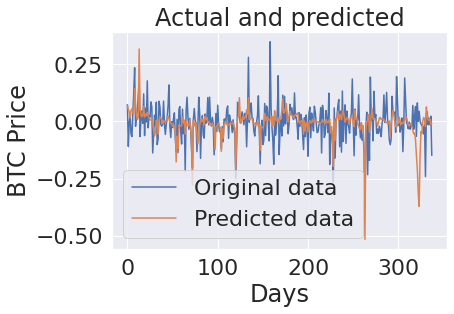

In [39]:
pred = model_best.predict(X_test)
original = Y_test
plt.title('Actual and predicted')
plt.plot(original, label = 'Original data')
plt.plot(pred, label = 'Predicted data')
plt.xlabel('Days')
plt.ylabel('BTC Price')
plt.legend()
plt.show()

In [40]:
matrix = confusion_matrix(Y_test > 0, pred > 0)
matrix

array([[112,  63],
       [ 61, 102]])

In [41]:
print(f"Porcentaje de bajadas acertadas: {matrix[0, 0] / np.sum(matrix[:, 0]) * 100:0.2f}%")
print(f"Porcentaje de subidas acertadas: {matrix[1, 1] / np.sum(matrix[:, 1]) * 100:0.2f}%")
acc = (matrix[0, 0] + matrix[1, 1]) / np.sum(matrix)

Porcentaje de bajadas acertadas: 64.74%
Porcentaje de subidas acertadas: 61.82%


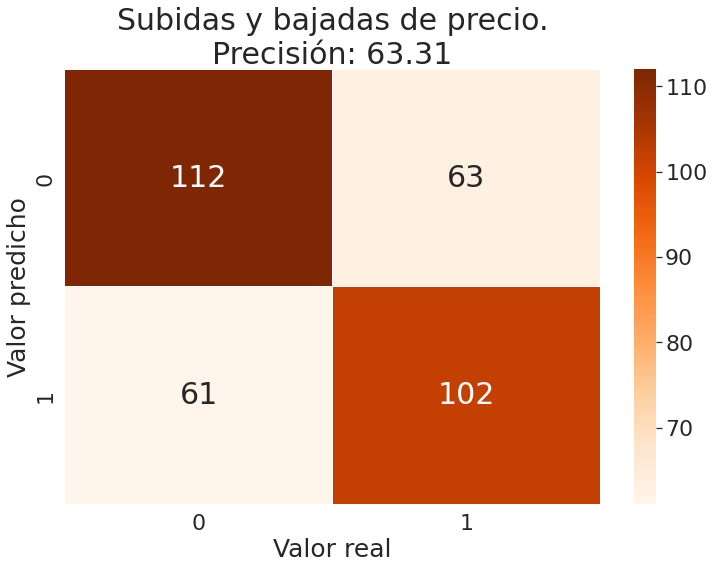

In [42]:
plot_confusion_matrix(Y_test > 0, pred > 0, 
                      f"Subidas y bajadas de precio.\nPrecisión: {acc*100:.2f}")